In [102]:
import zipfile
import cv2
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [103]:
Pi = 3.14159265358979323846

def knn_graph(Data, method, k):
    """
    计算k近邻图

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - k: 最近邻的数量

    Returns:
    - knn_graph: k近邻图的邻接矩阵，W[i, j]表示样本点i和j之间是否相连
    """
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_graph = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_graph, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        # 将样本点i与其最近邻之间的权重设置为1
        for j in indices[i]:
            knn_graph[i, j] = 1
            knn_graph[j, i] = 1  # 由于是无向图，因此也需要设置对称位置的权重为1
    return knn_graph, distances

# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data, distances): 
    n = Data.shape[0] # 数据集的大小
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 计算k最近邻索引矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix, neighbors= np.zeros((n, n))
        radius = compute_avg_radius(Data, distances)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 选择半径内的点作为邻居
            if len(neighbors) > n/2:  # 如果邻居数量超过 n/2
                sorted_indices = np.argsort(distances[i, neighbors])  # 根据距离排序邻居点的索引
                selected_neighbors = neighbors[sorted_indices[:int(n/2)]]  # 仅选择最近的 n/2 个点作为邻居
                adjacency_matrix[i, selected_neighbors] = 1 # 更新邻接矩阵
                adjacency_matrix[selected_neighbors, i] = 1 # 邻接矩阵为对称矩阵
            else:
                adjacency_matrix[i, neighbors] = 1
                adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, n_neighbors)
    if method == 'knn':
        for i in range(n):
            # 获取与样本点i相连的样本点索引
            connected_indices = np.where(adjacency_matrix[i] == 1)[0]
            # 计算样本点i与相连样本点之间的相似度
            for j in connected_indices:
                # 使用高斯核函数计算相似度
                Weight_matrix[i, j] = np.exp(-1 * distances[i, j] ** 2 / t)
                Weight_matrix[j, i] = Weight_matrix[i, j]  # 对称矩阵
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if adjacency_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    global_similarity = np.exp(-distances ** 2 / t)
    # 使用全局相似度修正权重矩阵
    Weight_matrix += global_similarity
    return Weight_matrix  


def LPP(Data, n_components, n_neighbors, t):
    """
    进行LPP算法，得到特征映射后的数据集

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - n_components: 降维后的维度
    - n_neighbors: 最近邻的数量
    - t: 高斯核函数的参数

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    """
    # Step 1: 计算权重矩阵
    method= 'knn'
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=n_components+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:n_components + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

显示示例人脸图像


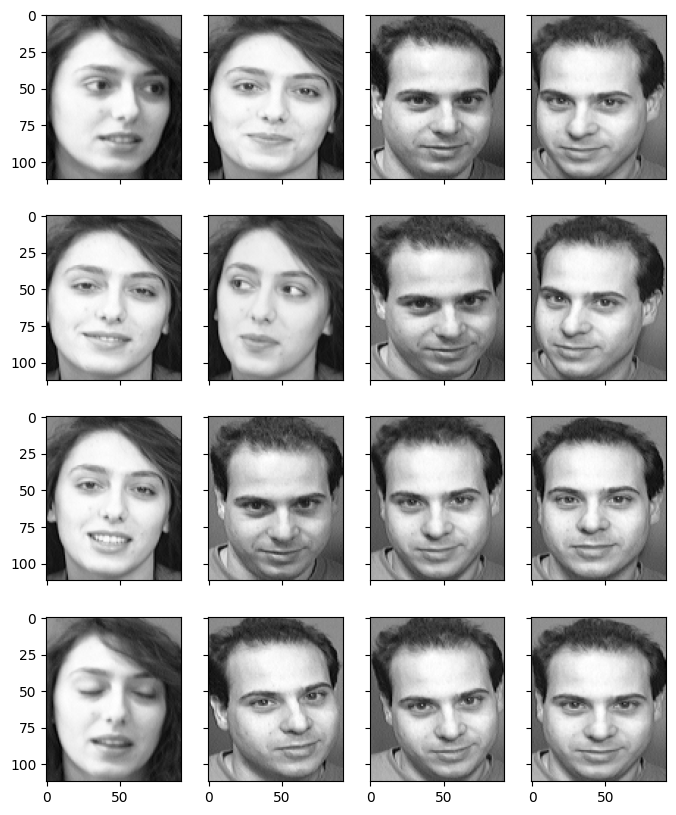

人脸图像形状: (112, 92)
类别数量: 10
图像数量: 100


In [104]:
# 从zip文件中读取人脸图像
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # 不是人脸图像
        with facezip.open(filename) as image:
            # 如果我们解压了zip文件，可以使用cv2.imread(filename)代替
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)


# 使用matplotlib显示示例人脸图像
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
faceimages = list(faces.values())[-16:] # 取最后16张图像
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("显示示例人脸图像")
plt.show()

# 打印一些细节
faceshape = list(faces.values())[0].shape
print("人脸图像形状:", faceshape)

# 从文件名中提取类别
classes = set(filename.split("/")[0] for filename in faces.keys())

print("类别数量:", len(classes))
print("图像数量:", len(faces))

In [105]:
from lpproj import LocalityPreservingProjection

权重矩阵形状: (40, 86)
显示特征脸


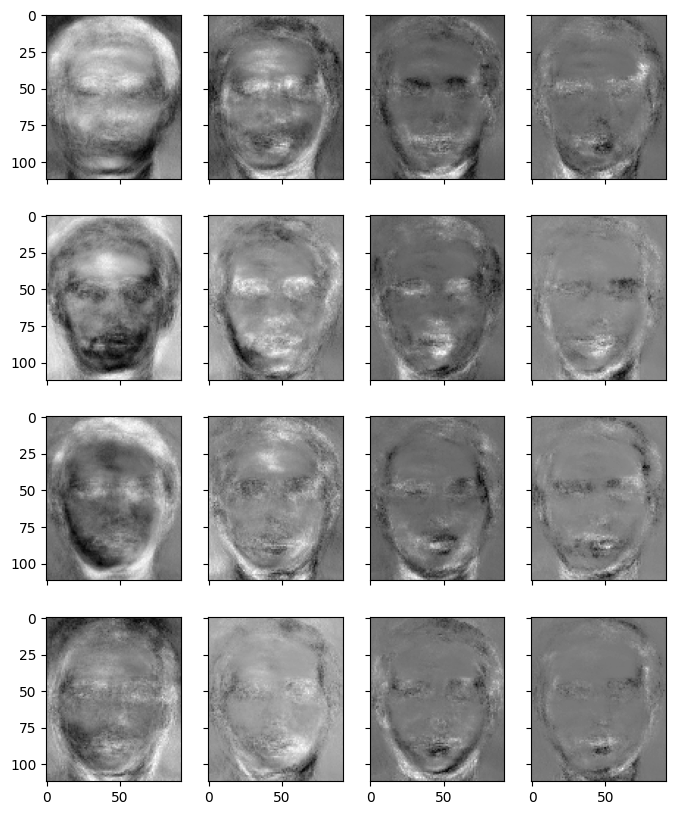

In [106]:
# 加载人脸数据集
facematrix = []
facelabel = []
for key, val in faces.items():
    if key.startswith("s10/"):
        continue # 这是我们的测试集
    if key == "s3/10.pgm":
        continue # 这是我们的测试集
    if key == "s8/2.pgm":
        continue # 这是我们的测试集
    if key == "s7/6.pgm":
        continue # 这是我们的测试集
    if key == "s8/4.pgm":
        continue # 这是我们的测试集
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

# 创建一个NxM矩阵，其中N为图像数量，M为每个图像的像素数
facematrix = np.array(facematrix)

# 转置facematrix以匹配矩阵乘法的预期形状
facematrix = facematrix.T

# 应用LPP并选择前K个主成分作为特征脸
n_components = 40
n_neighbors = 3200
t = 64000

# eigenfaces = LPP(facematrix, n_components, n_neighbors, t)
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components=n_components)
lpp.fit(facematrix)
#eigenfaces = lpp.transform(facematrix)

eigenfaces = LPP(facematrix, n_components, n_neighbors, t)

# 生成权重矩阵，其中K为特征脸数量，N为样本数量
weights = eigenfaces.T @ facematrix
print("权重矩阵形状:", weights.shape)

# 显示前16个特征脸
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faces["s1/1.pgm"].shape), cmap="gray")
print("显示特征脸")
plt.show()

In [107]:
def test_image(image_path, eigenfaces, mean_face, facelabel, weights):
    # 读取测试图像
    test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    test_image_flatten = test_image.flatten()

    # 加载测试图像数据
    test_data = test_image_flatten.reshape(1, -1)

    # 计算测试图像的权重向量
    query_weight = eigenfaces.T @ (test_data.T - mean_face)

    # 计算测试图像与数据集中每个人脸的欧氏距离
    euclidean_distances = np.linalg.norm(weights - query_weight, axis=0)

    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    best_match_label = facelabel[best_match_index]

    return best_match_label, euclidean_distances[best_match_index]


最佳匹配的人脸标签: s9
与测试图像的欧氏距离: 2163.89505618837


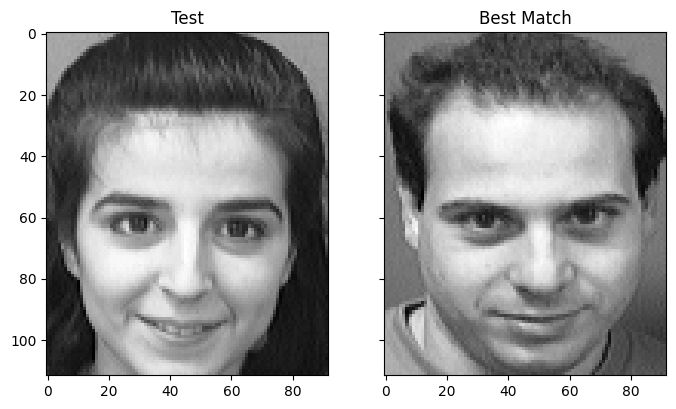

In [108]:
# 测试图像路径
image_path = "attface/s10/2.pgm"

# 测试图像并获取结果
mean_face = np.mean(facematrix, axis=0)
best_match_label, euclidean_distance = test_image(image_path, eigenfaces, mean_face, facelabel, weights)

# 打印测试结果
print("最佳匹配的人脸标签:", best_match_label)
print("与测试图像的欧氏距离:", euclidean_distance)
# 可视化
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
axes[0].imshow(test_image, cmap="gray")
axes[0].set_title("Test")
best_match_image = faces[best_match_label + "/1.pgm"]
axes[1].imshow(best_match_image, cmap="gray")
axes[1].set_title("Best Match")
plt.show()